## How to cluster HSNE hierarchies using Louvain clustering

Most of these dependencies are standard toolkit for data scientists

Not so standard:
igraph: https://igraph.org/

implementation of louvain algorithm: https://louvain-igraph.readthedocs.io/en/latest/install.html


In [1]:
from HSNE_parser import read_HSNE_binary
import pandas as pd
import numpy as np
import igraph as ig
import louvain

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix


Read the hierarchy from a HSNE binary file and print progress:

In [2]:
hsne = read_HSNE_binary(filename="/home/paul/Stage/LDA/Data/MNIST/mnist_no_labels_train.hsne", verbose=True)

Number of scales 4
Start reading first scale of size 60000
Done reading first scale..

Next scale: 1
Scale size: 12005
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 2
Scale size: 1765
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 3
Scale size: 128
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Total time spent parsing hierarchy and building objects: 4.142796


### MNIST data

Fetch raw MNIST data & labels

MNIST in CSV format available at: https://pjreddie.com/projects/mnist-in-csv/

In [3]:
# Read mnist data and put labels in seperate array
mnist = pd.read_csv("/home/paul/Stage/LDA/Data/MNIST/mnist_train.csv", header=None)
mnist_data = mnist.drop(columns=0)
mnist_labels = mnist[0].ravel()
del mnist

MNIST are handwritten digits 0-9 with each pixel corresponding to a grey value

Label: 5


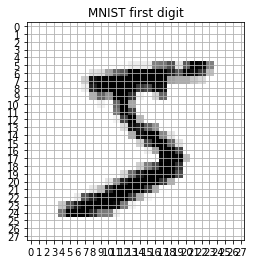

In [4]:
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()
inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - mnist_data.iloc[0])
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST first digit")
print("Label: %s" % (mnist_labels[0]))
plt.show()

Louvain Clustering on HSNE scale 2, 1765 datapoints:

note that Louvain clustering can take long on very large matrices (transition matrices of say, 200k * 200k or larger)

In [5]:
clusters = hsne.cluster_scale(1)
landmark_truth = mnist_labels[np.array(hsne[1].lm_to_original)]
adjusted_rand_score(clusters, mnist_labels)

0.8229102715136981

Calculate rand index of clustering versus labels:

Clustering is good; contingency matrix of clustering:

1's are split into 2 clusters of respectively 170 and 120 landmarks

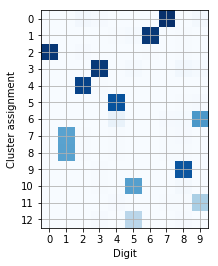

In [6]:
plt.imshow(contingency_matrix(list(clusters), mnist_labels), cmap='Blues')
plt.xticks([i for i in range(10)])
plt.yticks([ i for i in range(len(set(clusters)))])
plt.ylabel("Cluster assignment")
plt.xlabel("Digit")
plt.grid(b=True)
plt.show()

Why are the 1's split into more clusters? 

Inspection of the average values of each cluster shows that the clustering discerns between slanted and straight 1's, the straight ones might even contain some left slanted 1's.

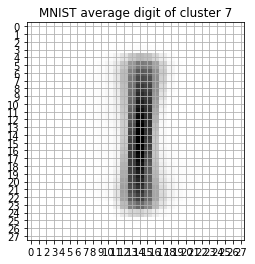

In [8]:
mask1 = np.array(clusters) == 7
mask2 = np.array(clusters) == 8
sum(mnist_data.iloc[mask1].values) / len(mask1)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[mask1].values) / len(mask1))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 7")
plt.show()

Right slanted 1's

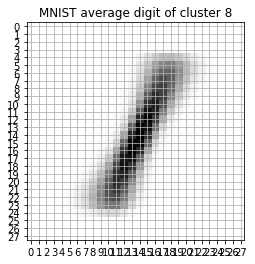

In [10]:
sum(mnist_data.iloc[mask2].values) / len(mask2)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[mask2].values) / len(mask2))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 8")
plt.show()

Performing SCHNEL clustering on a different scale gives different results

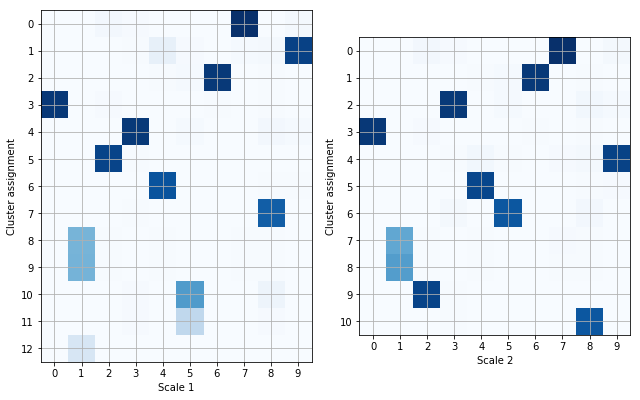

In [22]:
rcParams['figure.figsize'] = 9,9

fig, ax = plt.subplots(1, 2)
clusters = hsne.cluster_scale(1)
ax[0].imshow(contingency_matrix(list(clusters), mnist_labels), cmap='Blues')
ax[0].set_xticks([i for i in range(10)])
ax[0].set_yticks([ i for i in range(len(set(clusters)))])
ax[0].set_ylabel("Cluster assignment")
ax[0].set_xlabel("Scale 1")
ax[0].grid(b=True)


clusters = hsne.cluster_scale(2)
ax[1].set_xticks([i for i in range(10)])
ax[1].set_yticks([ i for i in range(len(set(clusters)))])
ax[1].set_ylabel("Cluster assignment")
ax[1].set_xlabel("Scale 2")
ax[1].grid(b=True)

ax[1].imshow(contingency_matrix(list(clusters), mnist_labels), cmap='Blues')
plt.tight_layout()
plt.show()

SCHNEL offers a 2 methods for calculating the mapping from landmark to datapoint. 
"label" propagation (get_datascale_mapping()) is extremely fast, but slightly less accurate than the "cluster" propagation method (get_map_by_cluster())

Both methods can be accessed individually, or by calling cluster_scale with proper_method "cluster" or "label"

In [12]:
#By taking the argmax of the AOI for each scale, this can de done without clustering first
hsne.get_datascale_mappings(scalenumber=3)
# or automatically after clustering
clusters = hsne.cluster_scale(3, prop_method='label')
#By using the result of clustering and the argmax of the sum of all points in each cluster of the AOI
clusters = hsne.cluster_scale(3, prop_method='cluster')